# Assignment 1 - class scheduling

## Initialization

In [187]:
import matplotlib.pyplot as plt

### Utility functions

In [183]:
class Timeslot():
    def __init__(self, start, end, color, title):
        self.start = start
        self.end = end
        self.color = color
        self.title = title

def applyTimeslots(offset, limit, timeslots, ax):
    for timeslot in timeslots:
        ax.fill_between([offset, limit], [timeslot.start + 0.05, timeslot.start + 0.05], [timeslot.end - 0.05,timeslot.end - 0.05], color=timeslot.color, edgecolor='k', linewidth=0.5, alpha=0.4
                        )
        ax.text(float(limit - offset) / 2 + offset, (timeslot.start + timeslot.end) / 2, timeslot.title, ha="center", va="center", fontsize=12)
        
def plotDay(timeslots):
    width = 10
    height = 8
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    ax.set_ylabel("Time")
    ax.axes.get_xaxis().set_visible(False)
    fig.gca().invert_yaxis()

    applyTimeslots(margin, width - margin, timeslots, ax)
    
    ax.set_title("Day")
    
    plt.show()
    
def plotWeek(timeslotDays):
    width = 15
    height = 8
    weekdays = 7
    
    fig = plt.figure(figsize=(width, height))
    
    margin = 0.3
    
    ax = fig.add_subplot(111)
    ax.yaxis.grid()
    ax.set_ylabel("Time")
    #ax.axes.get_xaxis().set_visible(False)
    
    fig.gca().invert_yaxis()
    
    dayWidth = width / weekdays
    
    def genDays(): 
        days = ["Monday", "Tuesday", "Wensday", "Thursday", "Friday", "Saturday", "Sunday"]

        for i, day in enumerate(days):
            yield (day, i * dayWidth + (dayWidth / 2))
            
    tickedDays = list(genDays())
    
    plt.xticks(list(map(lambda x: x[1], tickedDays)), list(map(lambda x: x[0], tickedDays)))
    
    for i, dayTimeslots in enumerate(timeslotDays):
        offset = i * dayWidth
        
        applyTimeslots(offset, offset + dayWidth, dayTimeslots, ax)

    
    ax.set_title("Day")
    
    plt.show()
    
    

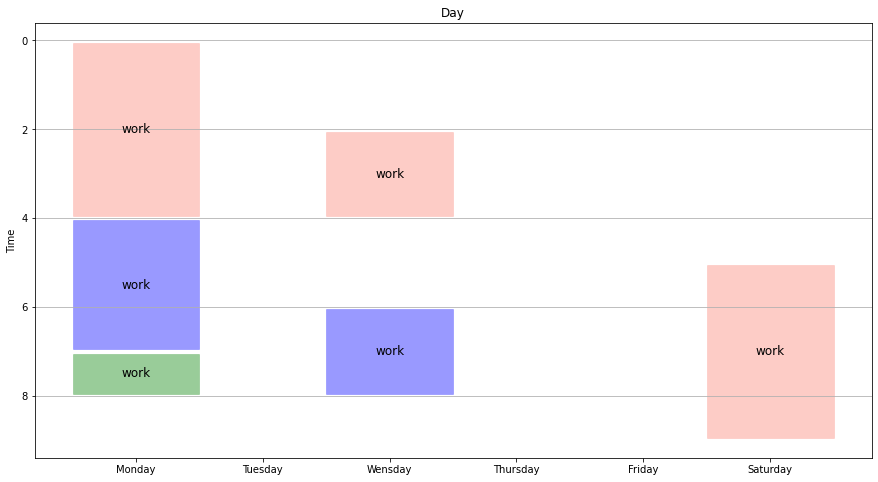

In [184]:
slots1 = [Timeslot(0, 4, "salmon", "work"), Timeslot(4, 7, "Blue", "work"), Timeslot(7, 8, "Green", "work")]
slots2 = []
slots3 = [Timeslot(2, 4, "salmon", "work"), Timeslot(6, 8, "Blue", "work")]
slots4 = []
slots5 = []
slots6 = [Timeslot(5, 9, "salmon", "work")]
slots7 = []

plotWeek([slots1, slots2, slots3, slots4, slots5, slots6, slots7])

## Model

## Initial description

We have:
* $P = (h,d,w)| h \in \text{Hours, } d \in \text{Days, } w \in \text{Weeks}$ 
* Rooms $R$
* Classes $E$ with duration $\ell(e), e \in E$
* Presedence digraph $D = (E, A)\text{, } uv \in A \text{ for } u, v \in E$
* Students $S$ and teachers $T$ with:
    * Enrollments $Q = E_s \subset E | s \in S$
    * Teaching duties $D = D_t \subset E | t \in T$
    * Unavailabilites $\mathcal{U} = U_t \subset P | t \in T$
* Preassignment $M = (e,r,p) | e \in E, r \in R, p \in P$

## Model interpretation

There should not be more than one event per room for the designated time.
$$x_{erp} \in \{0, 1\}$$
$$\sum_{p \in P, r \in R} x_{erp} = 1, \forall e \in E$$

An event should use the whole timeslot.
$$\sum_{r \in R} \sum_{(h,d,w) \in P} \sum^{\ell(e)}_{i=0} x_{er(h + i,d,w)} = \ell(e), \forall e \in E$$
For every event, there must exist a sum of successive times

$$\sum_{e \in E} \, \sum^t_{i=max(0, t - \ell(e) + 1} x_{e,r,(i,d,w)} \leq 1, \, \forall t \in T, \, \forall r \in R$$

Two rooms may never be occupied at the same time.
$$\sum_{r \in R, \, (h,d,w) \in P} x_{erp}= 1$$

A teacher may not teach two classes at the same time.
$$\sum t_{hdw} = 1, \forall h \in H$$

The teachers must teach at the preassigned times. ??? removed from assignment.
$$e_m = 1, \forall m \in M$$
$$r_m = 1, \forall m \in M$$
$$p_m = 1, \forall m \in M$$

There is at most one event per day per course.
$$\sum e_{dc} \leq 1, \forall d \in D, \, \forall c \in C$$

Classes must take presedence (day for class $u$ must be before day for class $v$, in week $w$ (I am unsure if the presedence graph takes weeks into account, so I'm explicit)).
$$d_{uw} < d_{vw}, \forall uv \in A, \, (\_, d, w) \in P, \, u,v \in E $$

Teachers may not be allocated when not available.
$$t_{hdw} = 0, \, (h,d,w) \in U_t, \, t \in T $$

Teachers should teach their respective class, thus a teacher should be allocated at the same time as a given class they teach.
$$t = 1 \land e  = 1, \, \forall e \in D_t, \, t \in T$$

Students should (try to) attend a class, this is the first soft constraint since overlapping classes cannot be avoided.\
We use a variable to express how many classes a student is attending at once, which should be minimized.\
First we express the amount of overlapping classes at a given time.
$$c_{s,(h,d,w)} = \sum e_{(h,d,w)} - 1, \, e \in Q_s$$
Then we do all time + student combinations.
$$a = \sum c_{s,(h,d,w)}, \, s \in S, \, (h,d,w) \in P$$

## Code

### Initilization

In [190]:
import pyomo.environ as po
import src.data as imp

dataImporter = imp.Data("data/small")

slots = dataImporter.slots
banned = dataImporter.banned
events = dataImporter.events
teachers = dataImporter.teachers
students = dataImporter.students

In [191]:
def prepareModel():
    m = po.ConcreteModel("timetable")